# Task 1 - ANN Model

---
## Import

In [1]:
import keras.models
import pandas as pd
import tensorflow as tf
from pyexpat import model
from tensorflow.keras import layers, losses, Input, Sequential
from keras_tuner.tuners import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import sys
from utils.tensorflow_preprocessing import prepare_image_target_dataset
from keras.callbacks import EarlyStopping, ProgbarLogger

---
## Prepare dataset

In [3]:
save_path = "../data/processed/csv/"

train_X = pd.read_csv(save_path + 'train_X.csv')
val_X = pd.read_csv(save_path + 'val_X.csv')
test_X = pd.read_csv(save_path + 'test_X.csv')

In [4]:
train_class_ds, class_encoder = prepare_image_target_dataset(train_X, target_name="Class")
val_class_ds, _ = prepare_image_target_dataset(val_X, target_name="Class", label_encoder=class_encoder)
test_class_ds, _ = prepare_image_target_dataset(test_X, target_name="Class", label_encoder=class_encoder)

---
## Model training

### Define model

In [10]:
# Basic Model Training
def create_model():
    model = Sequential([
        Input(shape=(256, 256, 3)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3, seed=21),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3, seed=21),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3, seed=21),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3, seed=21),
        layers.Dense(6, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model


### Train model

In [11]:
# Train the model
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
basic_model = create_model()
epochs = 50
history = basic_model.fit(train_class_ds, epochs=epochs, batch_size=32, validation_data=val_class_ds, callbacks=[early_stopping, ProgbarLogger()])

### Evaluate model

In [7]:
# Evaluate the model
train_loss, train_accuracy = basic_model.evaluate(test_class_ds)
print(f'val Loss: {train_loss:.4f}')
print(f'val Accuracy: {train_accuracy:.4f}')

val_loss, val_accuracy = basic_model.evaluate(test_class_ds)
print(f'val Loss: {val_loss:.4f}')
print(f'val Accuracy: {val_accuracy:.4f}')

test_loss, test_accuracy = basic_model.evaluate(test_class_ds)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

564/564 [==============================] - 24s 42ms/step - loss: 0.5967 - accuracy: 0.8221
val Loss: 0.5967
val Accuracy: 0.8221
564/564 [==============================] - 21s 37ms/step - loss: 0.5957 - accuracy: 0.8224
val Loss: 0.5957
val Accuracy: 0.8224
564/564 [==============================] - 21s 36ms/step - loss: 0.5958 - accuracy: 0.8228
Test Loss: 0.5958
Test Accuracy: 0.8228


In [12]:
basic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_5 (Dense)             (None, 128)               25165952  
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                     

In [ ]:
# Visualize the training history of the basic model
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training History')
    plt.show()

plot_training_history(history)

---
## Optimization

In [ ]:
# Hyperparameter Tuning
def build_model(hp):
    model = Sequential([
        Input(shape=(256, 256, 3)),
        layers.Flatten(),
        layers.Dense(hp.Choice('dense1_units', [128, 256]), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('dropout1_rate', [0.3, 0.5]), seed=21),
        layers.Dense(hp.Choice('dense2_units', [64, 128]), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('dropout2_rate', [0.3, 0.5]), seed=21),
        layers.Dense(hp.Choice('dense3_units', [64, 128]), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('dropout3_rate', [0.3, 0.5]), seed=21),
        layers.Dense(hp.Choice('dense4_units', [32, 64]), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('dropout4_rate', [0.3, 0.5]), seed=21),
        layers.Dense(6, activation='softmax')
    ])

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    seed=42,
    directory='../data/tuner_results',
    project_name='task_1_ANN'
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_class_ds,
             epochs=5,
             validation_data=val_class_ds,
             callbacks=[early_stopping, ProgbarLogger()])

In [ ]:
tuned_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Evaluate the best model
tuned_test_loss, tuned_test_accuracy = tuned_model.evaluate(test_class_ds)
print(f'Tuned Model Test Loss: {tuned_test_loss:.4f}')
print(f'Tuned Model Test Accuracy: {tuned_test_accuracy:.4f}')

In [ ]:
# Compare the performance of the basic model and the best model
models = ['Basic Model', 'Tuned Model']
accuracies = [test_accuracy, tuned_test_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.show()


---
## Model selection

In [ ]:
best_model = None
if test_accuracy >= tuned_test_accuracy:
    best_model = basic_model
else:
    best_model = tuned_model

---
## Testing

In [10]:
# Visualize the confusion matrix
def plot_confusion_matrix(model, test_data, label_encoder):
    y_true = []
    y_pred = []
    for images, labels in test_data:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    cm = confusion_matrix(y_true, y_pred)

    # Get the decoded class labels
    class_labels = label_encoder.inverse_transform(np.unique(y_true))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

1/1 [==============================] - 0s 141ms/step


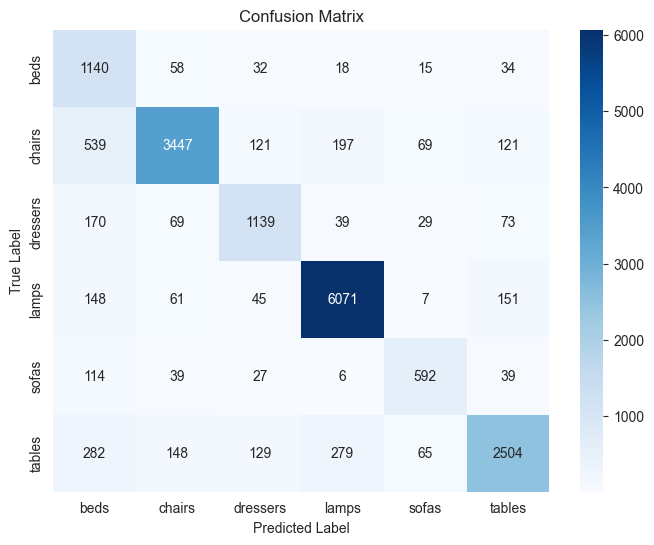

In [11]:
plot_confusion_matrix(best_model, test_class_ds, class_encoder)

In [12]:
def visualize_predictions(model, test_data, label_encoder, num_samples=5):
    for images, labels in test_data.take(1):
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)

        plt.figure(figsize=(15, 12))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow((images[i].numpy() * 255).astype('uint8'))
            true_label = label_encoder.inverse_transform([labels[i]])[0]
            pred_label = label_encoder.inverse_transform([predicted_labels[i]])[0]
            plt.title(f"True: {true_label}, Pred: {pred_label}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

1/1 [==============================] - 0s 43ms/step


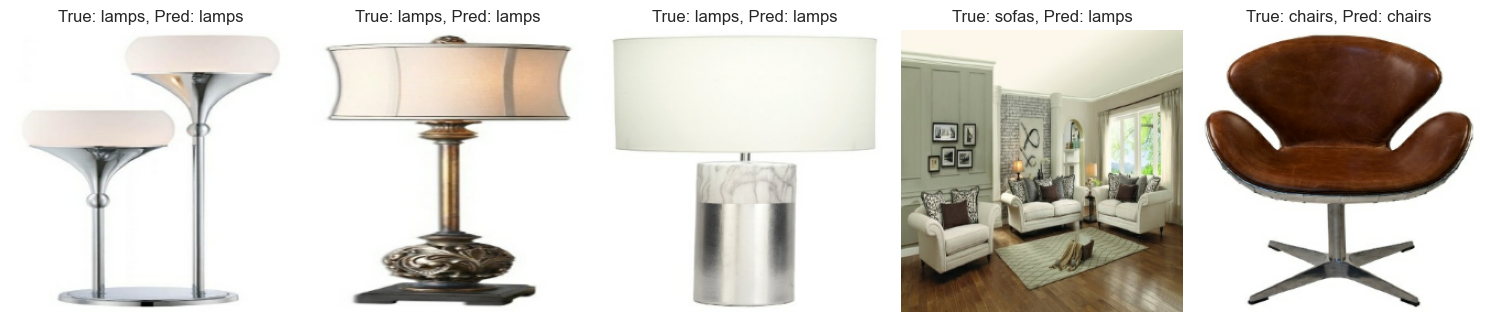

In [13]:
visualize_predictions(best_model, test_class_ds, class_encoder)

---
## Save model

In [13]:
from pathlib import Path

# Create paths
path = '../data/models'
processed_model_dir = Path(path)
processed_model_dir.mkdir(parents=True, exist_ok=True)

basic_model.save(path + '/' + 'task-1-ANN-best-backup.keras')